In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Input, Add, Activation, Dense, Flatten
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import keras

In [2]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_CLASSES = 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/Capstone new'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def create_data_generators():
    print("Creating data generators...")
    train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,  # Rotate images by up to 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10%
    height_shift_range=0.1,  # Shift images vertically by 10%
    shear_range=0.1,  # Shear transformation
    zoom_range=[0.8, 1.2],  # Zoom in and out
    brightness_range=[0.8, 1.2],  # Adjust brightness
    horizontal_flip=False,  # Do not flip horizontally
    fill_mode='nearest',  # Fill in new pixels
    validation_split=0.2  # 20% for validation

)

    print(f"Checking training path: {train_path}")
    if not os.path.exists(train_path):
        raise ValueError(f"Training path not found: {train_path}")

    # Create generators with error handling
    try:
        train_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        validation_generator = train_datagen.flow_from_directory(
            train_path,
            classes=['Non Nutrition Facts', 'Nutrition Facts'],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        return train_generator, validation_generator

    except Exception as e:
        print(f"Error creating generators: {str(e)}")
        return None, None


In [5]:

def create_improved_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)

    # First convolution block
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Second convolution block
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Third convolution block with residual connection
    shortcut = Conv2D(256, (1, 1), padding='same')(x)  # Adjust shortcut to match dimensions
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)  # This reduces the spatial dimensions
    x = Dropout(0.25)(x)

    # Adjust the shortcut to match the output shape of x
    shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)  # Adjust shortcut dimensions

    # Adding the shortcut connection
    x = Add()([x, shortcut])  # Residual connection
    x = Activation('relu')(x)

    # Global Average Pooling layer
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model
# Example usage
model = create_improved_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 112, 112, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 1,380,418 (5.27 MB)

 Trainable params: 1,378,626 (5.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [6]:
def plot_training_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [7]:
def detect_nutrition_facts(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image could not be loaded.")
        return None, 0.0, None

    img_orig = img.copy()
    img_height, img_width = img.shape[:2]

    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    nutrition_box = None
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.4 <= aspect_ratio <= 3.0 and w * h > (img_height * img_width * 0.02):
                nutrition_box = approx
                break

    if nutrition_box is not None:
        cv2.drawContours(img_orig, [nutrition_box], -1, (0, 255, 0), 2)

        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [nutrition_box], -1, (255), -1)
        result = cv2.bitwise_and(img_orig, img_orig, mask=mask)

        result = cv2.resize(result, (IMG_WIDTH, IMG_HEIGHT))
        result = result / 255.0
        result = np.expand_dims(result, axis=0)

        prediction = model.predict(result)
        class_index = np.argmax(prediction, axis=1)[0]
        confidence = prediction[0][class_index]

        predicted_class = 'Nutrition Fact' if class_index == 1 else 'Non Nutrition Fact'
        print(f"Detected {predicted_class} with confidence: {confidence:.2f}")
        return img_orig, confidence, predicted_class, nutrition_box
    else:
        return img_orig, 0.0, None, None

Creating data generators...
Checking training path: /content/drive/MyDrive/Capstone new
Found 1013 images belonging to 2 classes.
Found 252 images belonging to 2 classes.

Data Generator Status:
Classes found: {'Non Nutrition Facts': 0, 'Nutrition Facts': 1}
Number of training samples: 1013
Number of validation samples: 252
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5561 - loss: 0.9160 - precision_1: 0.5561 - recall_1: 0.5561
Epoch 1: val_accuracy improved from -inf to 0.58730, saving model to nutrition_model-001-0.5873.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 507s 7s/step - accuracy: 0.5569 - loss: 0.9135 - precision_1: 0.5569 - recall_1: 0.5569 - val_accuracy: 0.5873 - val_loss: 0.6764 - val_precision_1: 0.5873 - val_recall_1: 0.5873
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6743 - loss: 0.5767 - precision_1: 0.6743 - recall_1: 0.6743
Epoch 2: val_accuracy did not improve from 0.58730
64/64 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.6754 - loss: 0.5755 - precision_1: 0.6754 - recall_1: 0.6754 - val_accuracy: 0.4643 - val_loss: 0.7688 - val_precision_1: 0.4643 - val_recall_1: 0.4643
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7646 - loss: 0.4756 - precision_1: 0.7646 - recall_1: 0.7646
Epoch 3: val_accuracy did not improve from 0.58730
64/64 ━━━━━━━━━━━━━━━━━

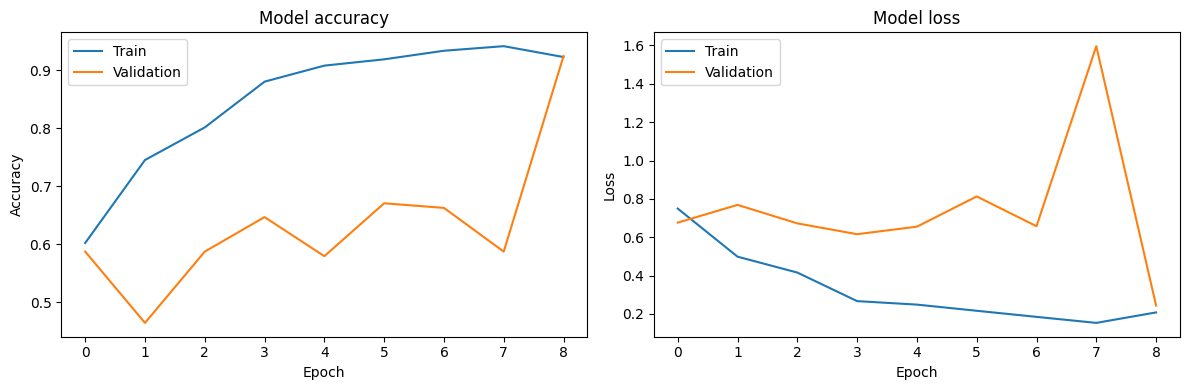

In [10]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.threshold:
            print(f"\nStopping training as validation accuracy has reached {self.threshold:.2f}.")
            self.model.stop_training = True


train_generator, validation_generator = create_data_generators()

# Check if generators were created successfully
if train_generator is not None and validation_generator is not None:
    # Create and train model
    model = create_improved_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    print("\nData Generator Status:")
    print("Classes found:", train_generator.class_indices)
    print("Number of training samples:", train_generator.samples)
    print("Number of validation samples:", validation_generator.samples)

    # Create checkpoint callback
    checkpoint = ModelCheckpoint(
        'nutrition_model-{epoch:03d}-{val_accuracy:.4f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    accuracy_threshold_callback = AccuracyThresholdCallback(threshold=0.85)
    # Train model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping, accuracy_threshold_callback],
    )
    # Plot training history
    plot_training_history(history)
else:
    print("Failed to create data generators. Please check the error messages above.")


In [11]:
model.save('my_model4.keras')

In [8]:
loaded_model = tf.keras.models.load_model('/content/my_model4.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Detected Nutrition Fact with confidence: 0.99


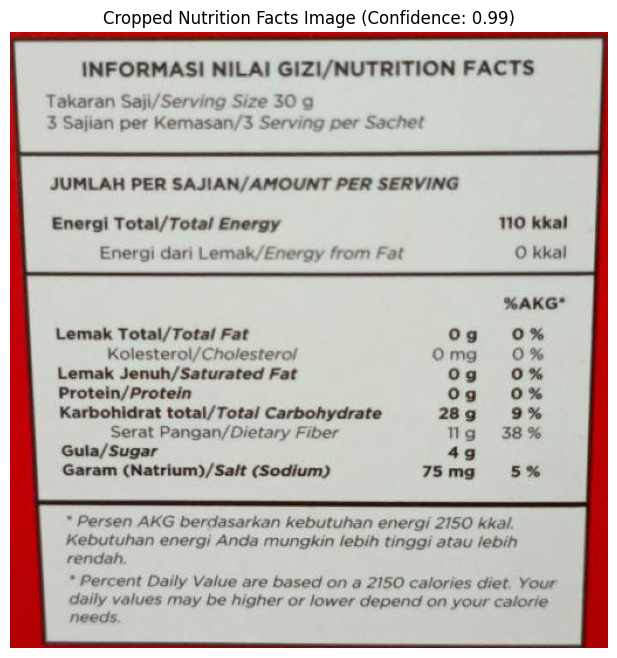

In [9]:
# Function to crop the image based on the contour
def crop_nutrition_facts(image_path, contour):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image could not be loaded.")
        return None

    # Crop based on bounding box
    x, y, w, h = cv2.boundingRect(contour)
    cropped_image = img[y:y+h, x:x+w]

    return cropped_image

# Using the detect_nutrition_facts function
test_image_path = "/content/drive/MyDrive/Tes Captone/e7bd869198bf9441c3f02d29ec0f5a2e.jpg"
if os.path.exists(test_image_path):
    result_image, confidence, predicted_class, contour = detect_nutrition_facts(test_image_path, loaded_model)

    # Always crop the image if a contour was found
    if contour is not None:
        cropped_image = crop_nutrition_facts(test_image_path, contour)

        # Display the cropped image
        if cropped_image is not None:
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Cropped Nutrition Facts Image (Confidence: {confidence:.2f})')
            plt.axis('off')
            plt.show()
    else:
        # If no contour is found, still attempt to crop (optional)
        print("No nutrition facts detected in the image. However, no cropping will be done since there's no contour.")
else:
    print(f"Error: The image file does not exist at the specified path: {test_image_path}")

In [17]:
!pip install paddleocr
!pip install paddlepaddle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0


In [10]:
from paddleocr import PaddleOCR

#PaddleOCR dengan bahasa Indonesia
ocr = PaddleOCR(use_angle_cls=True, lang='id')

# library gambar
image_path = cropped_image

# Proses OCR
results = ocr.ocr(image_path, cls=True)

# Menyaring hasil untuk kata "Gula" dan kandungan dalam gram (g)
kandungan_gula = []
for i, line in enumerate(results[0]):
    text = line[1][0]  # hasil ocr
    if "Gula" in text or "gula" in text:  # mencari kata gula
        # Cek kandungan gula ke teks terdekat
        if i + 1 < len(results[0]):
            next_text = results[0][i + 1][1][0]
            if "g" in next_text and any(char.isdigit() for char in next_text):  # mencari angka dan 'g' setelah teks gula
                kandungan_gula.append((text, next_text))  # Simpan "Gula" dan kandungannya

print("Kandungan gula")
for gula, kandungan in kandungan_gula:
    print(f"{gula}: {kandungan}")

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:09<00:00, 433.43it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/latin_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer/latin_PP-OCRv3_rec_infer.tar


100%|██████████| 9930/9930 [00:19<00:00, 516.04it/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:15<00:00, 137.44it/s]

[2024/11/25 05:13:01] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25,

[2024/11/25 05:13:03] ppocr DEBUG: dt_boxes num : 38, elapsed : 0.301241397857666
[2024/11/25 05:13:03] ppocr DEBUG: cls num  : 38, elapsed : 0.17455792427062988
[2024/11/25 05:13:06] ppocr DEBUG: rec_res num  : 38, elapsed : 2.6700243949890137
Kandungan gula
Gula/Sugar: 4g
